# Survival Analysis of Full Cohort 

**This notebook analyzes median overall survival and hazard ratios in patients with advanced or metastatic urothelial cancer. The analysis compares patients receiving first-line monotherapy with monotherapy checkpoint inhibitors (pembrolizumab [KEYNOTE-361] or atezolizumab [IMvigor130]) versus those receiving chemotherapy.** 

In [1]:
import numpy as np
import pandas as pd

import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

## Merge treatment information with death date

In [3]:
cohort = pd.read_csv('full_cohort.csv')

In [4]:
cohort.sample(3)

,PatientID,LineName,StartDate
6229,FA9D9F3647FB7,chemo,2014-09-15
5667,F29A2366D3BB5,chemo,2019-04-17
758,F48BC24638398,Pembrolizumab,2019-01-29


In [5]:
mortality = pd.read_csv('../data/Enhanced_Mortality_V2.csv')

In [6]:
mortality.sample(3)

,PatientID,DateOfDeath
4713,F34A2B5528372,2020-04
3492,FC4B4BA2A87B7,2016-02
3846,FCF3AF7DAEB26,2021-07


In [7]:
row_ID(cohort)

(6461, 6461)

In [8]:
row_ID(mortality)

(9040, 9040)

In [9]:
trial_df = pd.merge(cohort, mortality, on = 'PatientID', how = 'left')

In [10]:
trial_df.sample(3)

,PatientID,LineName,StartDate,DateOfDeath
793,FF7A2F5EFE12F,Pembrolizumab,2023-01-31,2023-04
1928,FDD5CCAC2BC85,Pembrolizumab,2022-10-11,NaN
5129,F802A10B766CC,chemo,2019-07-26,2021-02


In [11]:
row_ID(trial_df)

(6461, 6461)

In [12]:
# Patients with missing date of death
trial_df[trial_df.DateOfDeath.isna() == True].shape[0]

1960

In [13]:
# Patients with missing start date of treatment 
trial_df[trial_df.StartDate.isna() == True].shape[0]

0

In [14]:
trial_df[trial_df['StartDate'].str.len() < 10]  # Full date would be 10 characters (YYYY-MM-DD)

,PatientID,LineName,StartDate,DateOfDeath


In [15]:
trial_df[trial_df['DateOfDeath'].str.len() == 10].shape[0]

0

In [16]:
trial_df[trial_df['DateOfDeath'].str.len() == 7].shape[0] # 7 characters (YYYY-MM)

4495

In [17]:
trial_df[trial_df['DateOfDeath'].str.len() == 4].shape[0] # 4 characters (YYYY)

6

**StartDate is recorded at day-level precision, while DateOfDeath is recorded at month-level precision for patient de-identification. For DateOfDeath records with partial date information, Flatiron recommends the following imputation rules:**
- **When only month and year are available: Impute to the 15th day of the month**
- **When only year is available: Impute to July 1st (mid-year)**

In [18]:
trial_df['DateOfDeath'] = (
    np.where(trial_df['DateOfDeath'].str.len() == 4, trial_df['DateOfDeath'] + '-07-01', trial_df['DateOfDeath'])
)

In [19]:
trial_df['DateOfDeath'] = (
    np.where(trial_df['DateOfDeath'].str.len() == 7, trial_df['DateOfDeath'] + '-15', trial_df['DateOfDeath'])
)

In [20]:
trial_df['StartDate'] = pd.to_datetime(trial_df['StartDate'])
trial_df['DateOfDeath'] = pd.to_datetime(trial_df['DateOfDeath'])

In [21]:
trial_df.sample(3)

,PatientID,LineName,StartDate,DateOfDeath
4856,FE72E00067315,chemo,2022-12-02,NaT
3736,FE81F3AD10B58,chemo,2013-01-31,2013-03-15
1482,F04FB5D984BAF,Atezolizumab,2018-08-24,2019-09-15


## Patient censoring 

**For patients without a recorded date of death, we define their censor date as the last confirmed activity date in their EHR. This last confirmed activity date represents the most recent documented evidence of the patient being alive, as indicated by any of the following events:**
- **A clinical visit (recorded in the Visit table's VisitDate field)**
- **Oral medication activity (documented in Enhanced_AdvUrothelial_Orals table's StartDate or EndDate fields)**
- **Biomarker testing (logged in Enhanced_AdvUrothelialBiomarkers table's SpecimenCollectedDate field)**
- **Disease progression documentation (noted in Enhanced_AdvUrothelial_Progression table's LastClinicNoteDate or ProgressionDate fields)**

In [22]:
visit = pd.read_csv('../data/Visit.csv')
telemedicine = pd.read_csv('../data/Telemedicine.csv')
orals = pd.read_csv('../data/Enhanced_AdvUrothelial_Orals.csv')
biomarkers = pd.read_csv('../data/Enhanced_AdvUrothelialBiomarkers.csv')
progression = pd.read_csv ('../data/Enhanced_AdvUrothelial_Progression.csv')

### Visit

In [23]:
visit.sample(3)

,PatientID,PracticeID,VisitDate,VisitType,IsVitalsVisit,IsTreatmentVisit,IsLabVisit
323727,F599004EBEDEE,SC3260C6286CA,2020-09-02,Treatment,True,True,False
281137,F8B9838AA220E,S02B5DAC9B9B2,2021-12-06,Treatment,True,True,True
99373,FC01FCA309479,S0015D5ED587A,2017-11-17,Treatment,True,True,True


In [24]:
telemedicine.sample(3)

,PatientID,PracticeID,VisitDate
3040,FAEA5CA9FCD55,S507DCE5DD8C6,2022-01-26
2879,FAD669ED2CCCE,S507DCE5DD8C6,2022-07-06
4214,FBE9257A08544,S3A7162E98AAC,2021-01-14


In [25]:
visit_tele = (
    pd.concat([
        visit[['PatientID', 'VisitDate']],
        telemedicine[['PatientID', 'VisitDate']]
    ]))

In [26]:
visit_tele.sample(3)

,PatientID,VisitDate
486301,F93311772EC4E,2019-09-25
134856,F451143243C56,2023-06-22
274024,F7286C9535B04,2012-07-11


In [27]:
visit_tele['VisitDate'] = pd.to_datetime(visit_tele['VisitDate'])

In [28]:
visit_max = (
    visit_tele
    .query("PatientID in @trial_df.PatientID")  
    .groupby('PatientID', observed = True)['VisitDate']  
    .max()
    .to_frame(name = 'last_visit_date')          
    .reset_index()
)

In [29]:
visit_max.sample(3)

,PatientID,last_visit_date
595,F17A29FB78348,2022-03-10
2321,F5C8DBF674A13,2016-05-18
4942,FC46DD87057E9,2023-06-05


### Oral medicines

In [30]:
orals.sample(3)

,PatientID,DrugName,StartDate,EndDate,DateGranularity
209,FFD1235990CAE,Clinical Study Drug,2022-12-07,2023-01-03,Day
143,F59E5A6879307,Clinical Study Drug,2023-08-02,2023-09-26,Day
104,F2C0A77507EBF,erdafitinib,2020-02-07,2020-03-10,Day


In [31]:
orals['StartDate'] = pd.to_datetime(orals['StartDate'])
orals['EndDate'] = pd.to_datetime(orals['EndDate'])

In [32]:
orals_max = (
    orals
    .query("PatientID in @trial_df.PatientID")
    .assign(max_date = orals[['StartDate', 'EndDate']].max(axis = 1))
    .groupby('PatientID', observed = True)['max_date'].max()
    .to_frame(name = 'last_oral_date')
    .reset_index()
)

In [33]:
orals_max.sample(3)

,PatientID,last_oral_date
71,F953C468AFF5E,2016-07-05
34,F494934D917A0,2022-03-02
82,FA6A3306094C7,2017-03-30


### Biomarkers 

In [34]:
biomarkers.sample(1)

,PatientID,BiomarkerName,CellType,SpecimenCollectedDate,SpecimenReceivedDate,ResultDate,BiomarkerStatus,Gene,BiomarkerDetail,ExpressionLevel,SampleType,TissueCollectionSite,TestType,LabName,Assay,IHCClone,StainingIntensity,PercentStaining,CombinedPositiveScore
1841,F4F762D59C1C1,FGFR,NaN,2021-08-17,NaN,2021-09-23,Negative,NaN,NaN,NaN,Tissue,Primary site,NGS,Caris Life Sciences,NaN,NaN,NaN,NaN,NaN


In [35]:
biomarkers['SpecimenCollectedDate'] = pd.to_datetime(biomarkers['SpecimenCollectedDate'])

In [36]:
biomarkers_max = (
    biomarkers
    .query("PatientID in @trial_df.PatientID")
    .groupby('PatientID', observed = True)['SpecimenCollectedDate'].max()
    .to_frame(name = 'biomarkers_max')
    .reset_index()
)

In [37]:
biomarkers_max.sample(3)

,PatientID,biomarkers_max
1207,F798B4BF55C84,2022-09-19
1381,F8B7FBD8795DA,2016-06-20
534,F34B5F8BF8F7B,2022-12-28


### Progression

In [38]:
progression.sample(3)

,PatientID,ProgressionDate,ProgressionDateGranularity,IsRadiographicEvidence,IsPathologicEvidence,IsClinicalAssessmentOnly,IsMixedResponse,IsPseudoprogressionMentioned,LastClinicNoteDate
15475,FF36E66E33746,2023-01-05,Day,Yes,No,No,No,No,2023-07-21
11113,FB0D766ADFBE4,2013-07-01,Day,Yes,No,No,No,No,2014-03-27
809,F0C4806AEC59C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-24


In [39]:
progression['ProgressionDate'] = pd.to_datetime(progression['ProgressionDate'])
progression['LastClinicNoteDate'] = pd.to_datetime(progression['LastClinicNoteDate'])

In [40]:
progression_max = (
    progression
    .query("PatientID in @trial_df.PatientID")
    .assign(max_date = progression[['ProgressionDate', 'LastClinicNoteDate']].max(axis = 1))
    .groupby('PatientID', observed = True)['max_date'].max()
    .to_frame(name = 'progression_max')
    .reset_index()
)

In [41]:
progression_max.sample(3)

,PatientID,progression_max
3554,F8EF1FACB78B6,2023-10-11
1748,F46889D8710CF,2017-05-17
3097,F7C6054D8621C,2021-11-06


### Merging last EHR date

In [42]:
last_activity = pd.merge(visit_max, orals_max, on = 'PatientID', how = 'outer')
last_activity = pd.merge(last_activity, biomarkers_max, on = 'PatientID', how = 'outer')
last_activity = pd.merge(last_activity, progression_max, on = 'PatientID', how = 'outer')

In [43]:
row_ID(last_activity)

(6461, 6461)

In [44]:
# Find max of each row. 
last_activity = (
    last_activity
    .assign(last_activity = last_activity[['last_visit_date', 'last_oral_date', 'biomarkers_max', 'progression_max']].max(axis = 1))
    .filter(items = ['PatientID', 'last_activity'])
)

In [45]:
trial_df = pd.merge(trial_df, last_activity, on = 'PatientID')

In [46]:
row_ID(trial_df)

(6461, 6461)

In [47]:
trial_df.sample(3)

,PatientID,LineName,StartDate,DateOfDeath,last_activity
6259,F54F89C12381A,chemo,2016-07-14,2016-09-15,2016-08-04
5273,F6F1C0B9CF8A3,chemo,2015-09-23,2016-01-15,2016-01-12
1811,F0460BE65CE28,Pembrolizumab,2023-08-03,2023-09-15,2023-08-10


## Creating event and duration columns

In [48]:
trial_df.dtypes

PatientID                object
LineName                 object
StartDate        datetime64[ns]
DateOfDeath      datetime64[ns]
last_activity    datetime64[ns]
dtype: object

In [49]:
trial_df['event'] = trial_df['DateOfDeath'].notna().astype(int)

In [50]:
trial_df['end_date'] = trial_df['DateOfDeath'].fillna(trial_df['last_activity'])

In [51]:
trial_df['duration'] = (trial_df['end_date'] - trial_df['StartDate']).dt.days

In [52]:
trial_df.query('duration < 0')

,PatientID,LineName,StartDate,DateOfDeath,last_activity,event,end_date,duration
348,FF42B7E5B8676,Atezolizumab,2022-05-16,2022-05-15,2022-05-23,1,2022-05-15,-1
421,FD1A0A26124FA,Pembrolizumab,2018-03-20,2018-03-15,2018-03-26,1,2018-03-15,-5
479,FC39EEFCB7C05,Atezolizumab,2017-04-19,2017-04-15,2017-04-19,1,2017-04-15,-4
693,F948144982293,Pembrolizumab,2018-10-26,2018-10-15,2018-10-26,1,2018-10-15,-11
1070,FEEA076876F9A,Atezolizumab,2017-11-20,2017-11-15,2017-11-20,1,2017-11-15,-5
1442,F7B261828E21A,Atezolizumab,2016-08-22,2016-08-15,2016-08-22,1,2016-08-15,-7
1706,F2A70849BAE11,Atezolizumab,2016-07-25,2016-07-15,2016-07-25,1,2016-07-15,-10
1957,F077F7E307F5E,Atezolizumab,2022-06-22,2022-06-15,2022-06-22,1,2022-06-15,-7
2213,FA90CA0B34A4B,chemo,2022-09-21,2022-09-15,2022-09-22,1,2022-09-15,-6
2654,F93004DA5D3B1,chemo,2019-10-16,2019-10-15,2019-10-16,1,2019-10-15,-1


In [53]:
trial_df = trial_df.query('duration >= 0')

In [54]:
print(f'Number of patients receiving first-line chemotherapy: {trial_df.query('LineName == "chemo"').shape[0]}')
print(f'Number of patients receiving first-line pembrolizumab: {trial_df.query('LineName == "Pembrolizumab"').shape[0]}')
print(f'Number of patients receiving first-line atezolizumab: {trial_df.query('LineName == "Atezolizumab"').shape[0]}')

Number of patients receiving first-line chemotherapy: 4287
Number of patients receiving first-line pembrolizumab: 1484
Number of patients receiving first-line atezolizumab: 675


In [55]:
trial_df.groupby('LineName')['event'].value_counts(normalize = True)

LineName       event
Atezolizumab   1        0.776296
               0        0.223704
Pembrolizumab  1        0.667116
               0        0.332884
chemo          1        0.693259
               0        0.306741
Name: proportion, dtype: float64

## Calculating survival metrics 

### Checkpoint vs. chemotherapy 

In [56]:
kmf_checkpoint = KaplanMeierFitter()
kmf_chemo = KaplanMeierFitter()

kmf_checkpoint.fit(
    trial_df.query('LineName != "chemo"').duration/30,
    trial_df.query('LineName != "chemo"').event)

kmf_chemo.fit(
    trial_df.query('LineName == "chemo"').duration/30,
    trial_df.query('LineName == "chemo"').event)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 4287 total observations, 1315 right-censored observations>

<Axes: title={'center': '1L Checkpoint vs Chemotherapy'}, xlabel='Time (months)', ylabel='Survival probability'>

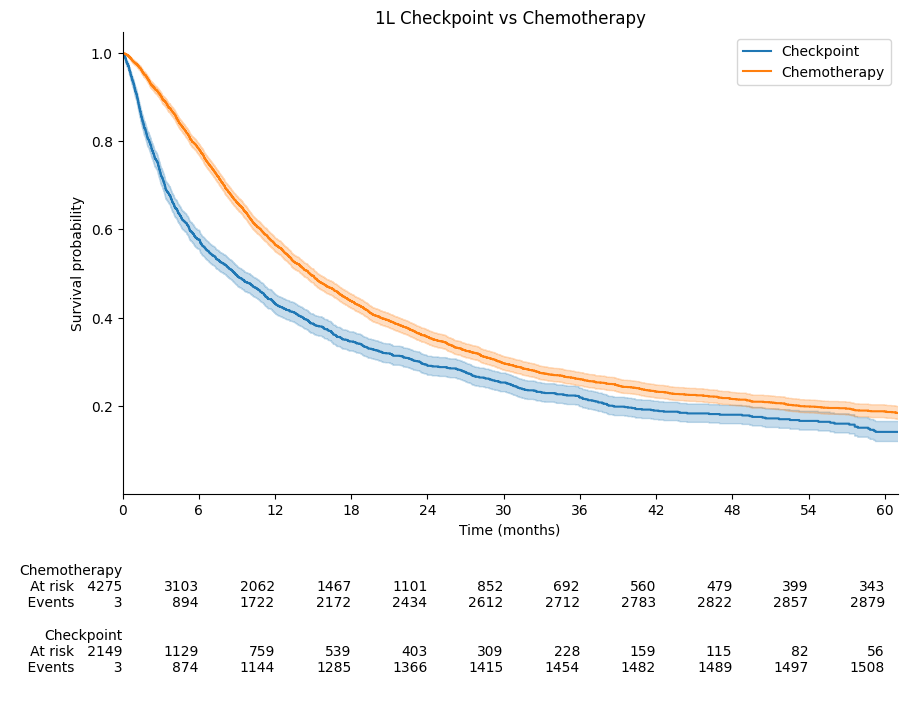

In [57]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot both curves
kmf_checkpoint.plot(label = 'Checkpoint', ci_show = True)
kmf_chemo.plot(label = 'Chemotherapy', ci_show = True)

# Customize the plot
plt.title('1L Checkpoint vs Chemotherapy')

plt.xlabel('Time (months)') 
plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)

plt.ylabel('Survival probability')

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_chemo, kmf_checkpoint, rows_to_show = ['At risk', 'Events'], labels = ['Chemotherapy', 'Checkpoint'])

In [58]:
median_checkpoint = kmf_checkpoint.median_survival_time_
median_chemo = kmf_chemo.median_survival_time_

print(f"Median survival time for checkpoint therapy: {median_checkpoint:.1f} months")
print(f"Median survival time for chemotherapy: {median_chemo:.1f} months")

Median survival time for checkpoint therapy: 8.9 months
Median survival time for chemotherapy: 14.7 months


In [59]:
cox_df = trial_df.copy()
cox_df['treatment'] = (cox_df['LineName'] != 'chemo').astype(int)
cox_df['duration_months'] = cox_df['duration'] / 30

cox_check_chemo = CoxPHFitter()
cox_check_chemo.fit(cox_df,
                    duration_col = 'duration_months',
                    event_col = 'event', 
                    formula = 'treatment')

<lifelines.CoxPHFitter: fitted with 6446 total observations, 1960 right-censored observations>

In [60]:
print(f"Hazard ratio: {cox_check_chemo.hazard_ratios_['treatment']:.2f} ({cox_check_chemo.summary.loc['treatment']['exp(coef) lower 95%']:.2f}, {cox_check_chemo.summary.loc['treatment']['exp(coef) upper 95%']:.2f})")

Hazard ratio: 1.38 (1.30, 1.47)


### Pembrolizumab vs. chemotherapy 

In [61]:
kmf_pembro = KaplanMeierFitter()
kmf_chemo = KaplanMeierFitter()

kmf_pembro.fit(
    trial_df.query('LineName == "Pembrolizumab"').duration/30,
    trial_df.query('LineName == "Pembrolizumab"').event)

kmf_chemo.fit(
    trial_df.query('LineName == "chemo"').duration/30,
    trial_df.query('LineName == "chemo"').event)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 4287 total observations, 1315 right-censored observations>

<Axes: title={'center': '1L Pembrolizumab vs Chemotherapy'}, xlabel='Time (months)', ylabel='Survival probability'>

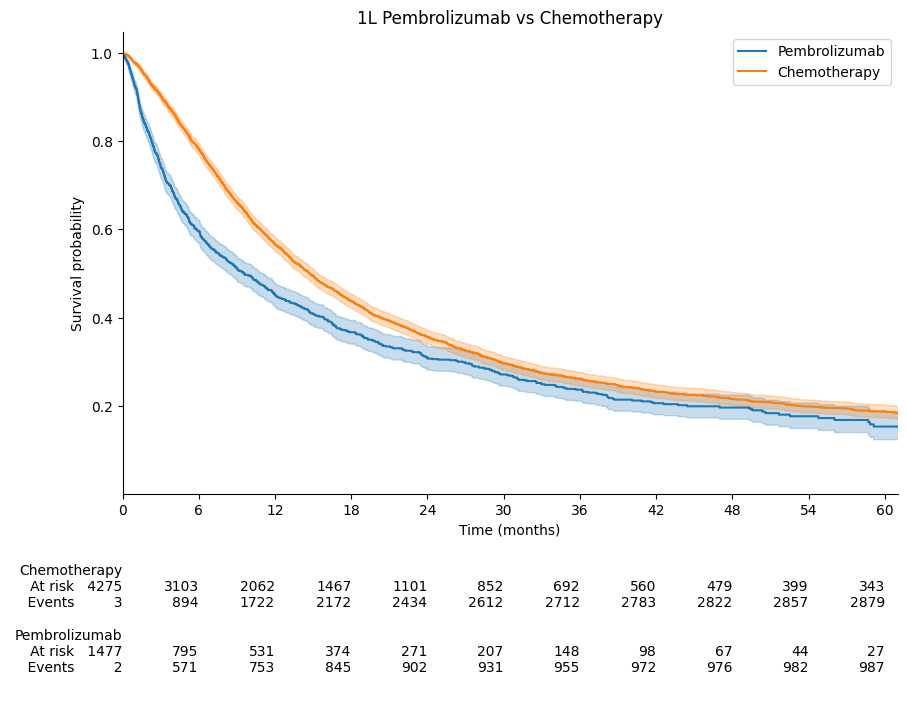

In [62]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot both curves
kmf_pembro.plot(label = 'Pembrolizumab', ci_show = True)
kmf_chemo.plot(label = 'Chemotherapy', ci_show = True)

# Customize the plot
plt.title('1L Pembrolizumab vs Chemotherapy')

plt.xlabel('Time (months)') 
plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)

plt.ylabel('Survival probability')

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_chemo, kmf_pembro, rows_to_show = ['At risk', 'Events'], labels = ['Chemotherapy', 'Pembrolizumab'])

In [63]:
median_pembro = kmf_pembro.median_survival_time_
median_chemo = kmf_chemo.median_survival_time_

print(f"Median survival time for real-world pembrolizumab: {median_pembro:.1f} months")
print(f"Median survival time for real-world chemotherapy: {median_chemo:.1f} months")
print()
print("Median survival time for KEYNOTE-361 pembrolizumab: 15.6 (12.1-17.9) months")
print("Median survival time for KEYNOTE-361 chemotherapy: 14.3 (12.3-16.7) months")

Median survival time for real-world pembrolizumab: 9.6 months
Median survival time for real-world chemotherapy: 14.7 months

Median survival time for KEYNOTE-361 pembrolizumab: 15.6 (12.1-17.9) months
Median survival time for KEYNOTE-361 chemotherapy: 14.3 (12.3-16.7) months


In [64]:
cox_pembro_df = trial_df.copy()
cox_pembro_df = cox_pembro_df.query('LineName != "Atezolizumab"')
cox_pembro_df['treatment'] = (cox_pembro_df['LineName'] == 'Pembrolizumab').astype(int)
cox_pembro_df['duration_months'] = cox_pembro_df['duration'] / 30

cox_pembro = CoxPHFitter()
cox_pembro.fit(cox_pembro_df,
               duration_col = 'duration_months',
               event_col = 'event', 
               formula = 'treatment')

<lifelines.CoxPHFitter: fitted with 5771 total observations, 1809 right-censored observations>

In [65]:
print(f"Hazard ratio real-world: {cox_pembro.hazard_ratios_['treatment']:.2f} ({cox_pembro.summary.loc['treatment']['exp(coef) lower 95%']:.2f}, {cox_pembro.summary.loc['treatment']['exp(coef) upper 95%']:.2f})")
print("Hazard ratio KEYNOTE-361: 0.92 (0.77-1.11)")

Hazard ratio real-world: 1.32 (1.22, 1.42)
Hazard ratio KEYNOTE-361: 0.92 (0.77-1.11)


### Atezolizumab vs. chemotherapy 

In [66]:
kmf_atezo = KaplanMeierFitter()
kmf_chemo = KaplanMeierFitter()

kmf_atezo.fit(
    trial_df.query('LineName == "Atezolizumab"').duration/30,
    trial_df.query('LineName == "Atezolizumab"').event)

kmf_chemo.fit(
    trial_df.query('LineName == "chemo"').duration/30,
    trial_df.query('LineName == "chemo"').event)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 4287 total observations, 1315 right-censored observations>

<Axes: title={'center': '1L Atezolizumab vs Chemotherapy'}, xlabel='Time (months)', ylabel='Survival probability'>

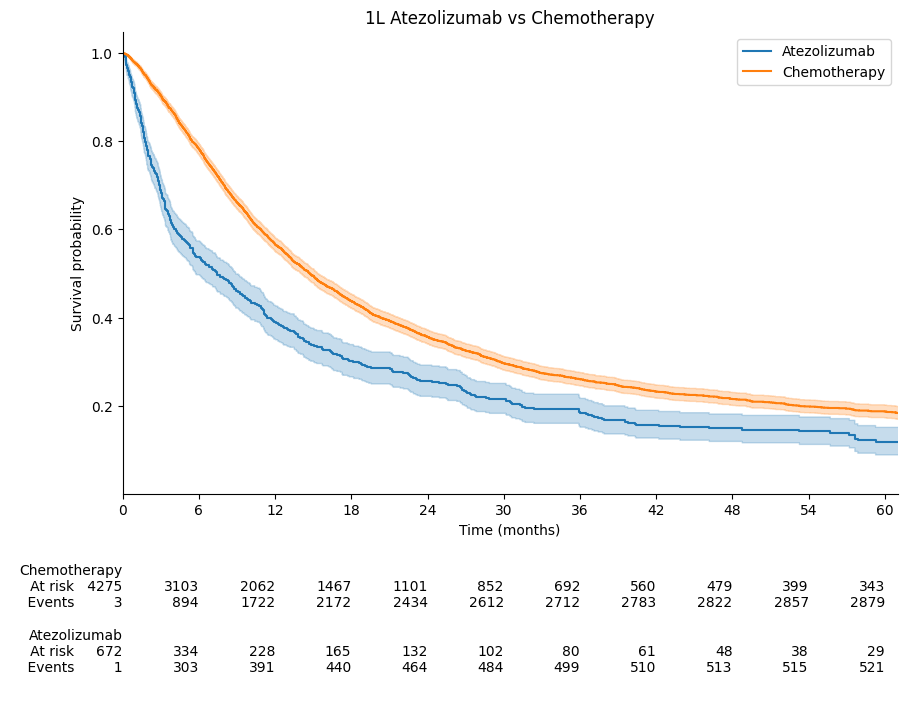

In [67]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot both curves
kmf_atezo.plot(label = 'Atezolizumab', ci_show = True)
kmf_chemo.plot(label = 'Chemotherapy', ci_show = True)

# Customize the plot
plt.title('1L Atezolizumab vs Chemotherapy')

plt.xlabel('Time (months)') 
plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)

plt.ylabel('Survival probability')

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_chemo, kmf_atezo, rows_to_show = ['At risk', 'Events'], labels = ['Chemotherapy', 'Atezolizumab'])

In [68]:
median_atezo = kmf_atezo.median_survival_time_
median_chemo = kmf_chemo.median_survival_time_

print(f"Median survival time for real-world atezolizumab: {median_atezo:.1f} months")
print(f"Median survival time for real-world chemotherapy: {median_chemo:.1f} months")

Median survival time for real-world atezolizumab: 7.4 months
Median survival time for real-world chemotherapy: 14.7 months


In [69]:
cox_atezo_df = trial_df.copy()
cox_atezo_df = cox_atezo_df.query('LineName != "Pembrolizumab"')
cox_atezo_df['treatment'] = (cox_atezo_df['LineName'] == 'Atezolizumab').astype(int)
cox_atezo_df['duration_months'] = cox_atezo_df['duration'] / 30

cox_atezo = CoxPHFitter()
cox_atezo.fit(cox_atezo_df,
               duration_col = 'duration_months',
               event_col = 'event', 
               formula = 'treatment')

<lifelines.CoxPHFitter: fitted with 4962 total observations, 1466 right-censored observations>

In [70]:
print(f"Hazard ratio real-world: {cox_atezo.hazard_ratios_['treatment']:.2f} ({cox_atezo.summary.loc['treatment']['exp(coef) lower 95%']:.2f}, {cox_atezo.summary.loc['treatment']['exp(coef) upper 95%']:.2f})")

Hazard ratio real-world: 1.55 (1.42, 1.71)
